In [ ]:
# Install required packages
!pip install -q segmentation-models-pytorch albumentations opencv-python scikit-image

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from scipy import ndimage
from skimage.measure import label, regionprops
from skimage.draw import ellipse_perimeter
import warnings
warnings.filterwarnings('ignore')
import json
# Set random seeds for reproducibility
torch.manual_seed(32)
np.random.seed(32)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
Using device: cuda


# 1. Data loading + EDA

Dataset Info:
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81

Total samples: 999

HC Statistics:
count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: head circumference (mm), dtype: float64

Pixel size Statistics:
count    999.000000
mean       0.139846
std        0.053005
min        0.049415
25%        0.108801
50%        0.128357
75%        0.157678
max        0.393280
Name: pixel size(mm), dtype: float64

 All files found!


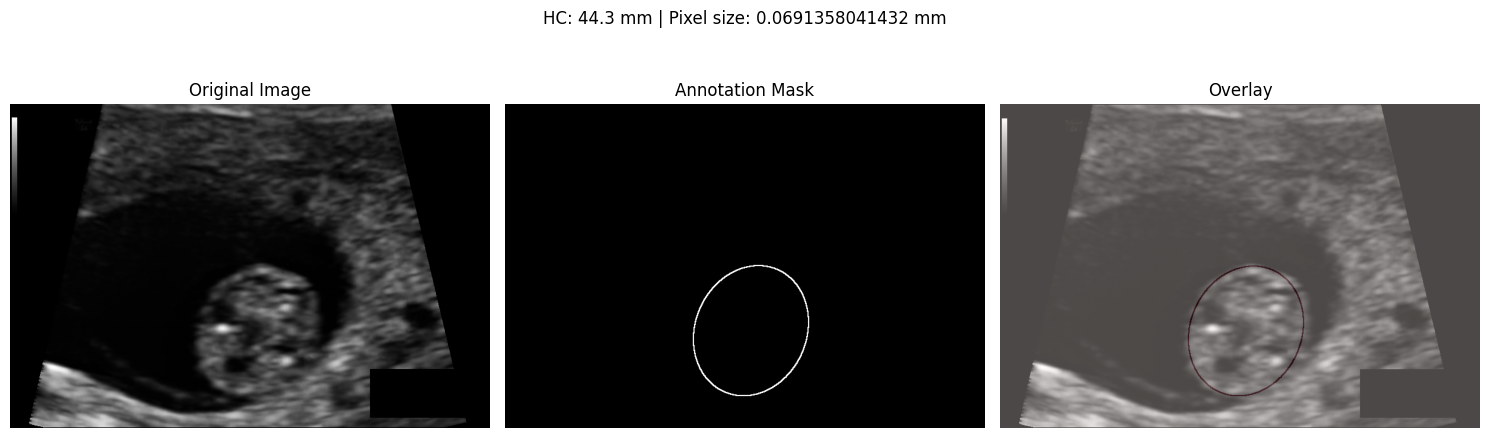

In [ ]:
# Load CSV
csv_path = '/content/training_set_pixel_size_and_HC.csv'
df = pd.read_csv(csv_path)

print("Dataset Info:")
print(df.head())
print(f"\nTotal samples: {len(df)}")
print(f"\nHC Statistics:\n{df['head circumference (mm)'].describe()}")
print(f"\nPixel size Statistics:\n{df['pixel size(mm)'].describe()}")

# Check if files exist
train_dir = '/content/train'
missing_files = []

for idx, row in df.iterrows():
    img_path = os.path.join(train_dir, row['filename'])
    mask_path = img_path.replace('.png', '_Annotation.png')

    if not os.path.exists(img_path):
        missing_files.append(img_path)
    if not os.path.exists(mask_path):
        missing_files.append(mask_path)

if missing_files:
    print(f"\n Missing {len(missing_files)} files")
    print(missing_files[:5])
else:
    print("\n All files found!")

# Visualize sample
sample_idx = 0
sample_row = df.iloc[sample_idx]
img_path = os.path.join(train_dir, sample_row['filename'])
mask_path = img_path.replace('.png', '_Annotation.png')

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Annotation Mask')
axes[1].axis('off')

axes[2].imshow(img, cmap='gray')
axes[2].imshow(mask, cmap='Reds', alpha=0.3)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.suptitle(f"HC: {sample_row['head circumference (mm)']} mm | Pixel size: {sample_row['pixel size(mm)']} mm")
plt.tight_layout()
plt.show()

## 1.2. Data Analysis


1. Checking file existence and mask quality...


Analyzing images: 100%|██████████| 999/999 [00:02<00:00, 409.57it/s]



ANALYSIS RESULTS

Total images: 999
Valid samples: 999
Missing files: 0
Empty masks: 0
Small masks (<100 pixels): 0
HC calculation issues: 0
HC outliers (>50% error): 0
Pixel size outliers: 13

VISUALIZING PROBLEMATIC SAMPLES
No problematic samples to visualize!

VISUALIZING GOOD SAMPLES (for comparison)


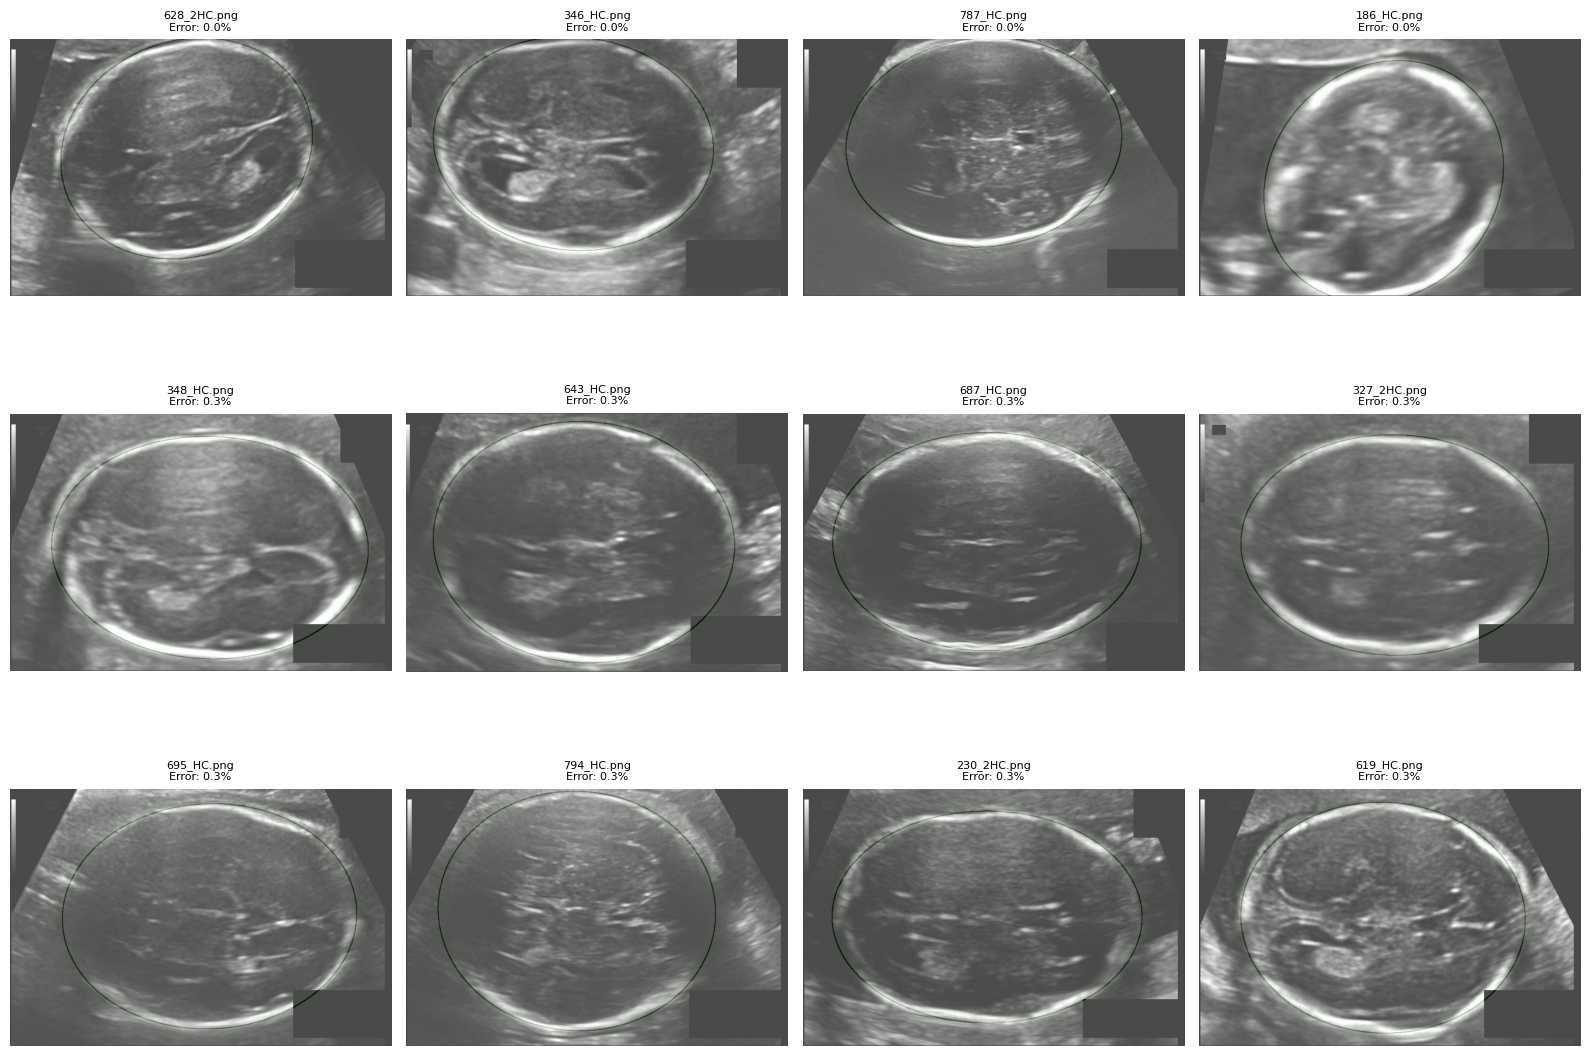


ERROR DISTRIBUTION ANALYSIS


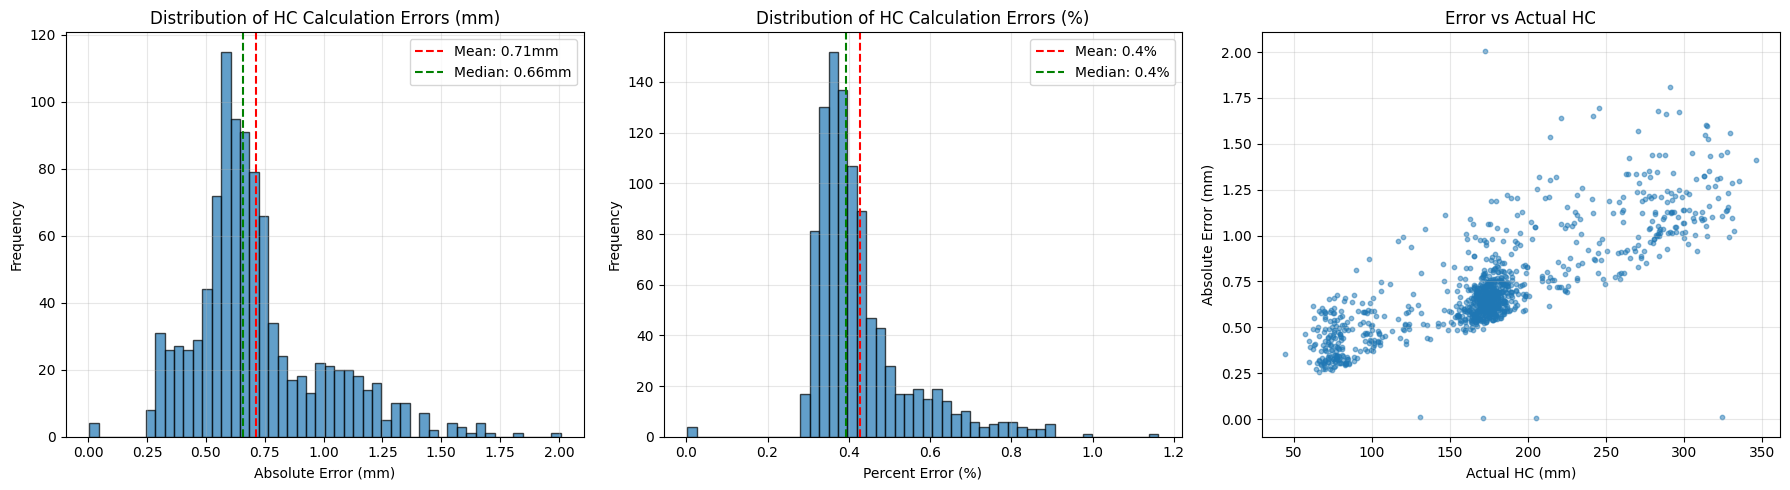


Error Statistics:
  Mean absolute error: 0.71 mm
  Median absolute error: 0.66 mm
  Std absolute error: 0.27 mm
  Max absolute error: 2.01 mm

  Mean percent error: 0.4%
  Median percent error: 0.4%

Analysis saved to: /content/dataset_analysis.json


In [ ]:
analysis_results = {
    'total_images': len(df),
    'missing_files': [],
    'empty_masks': [],
    'small_masks': [],
    'hc_calculation_issues': [],
    'hc_outliers': [],
    'pixel_size_outliers': [],
    'valid_samples': []
}

print("\n1. Checking file existence and mask quality...")
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing images"):
    filename = row['filename']
    img_path = os.path.join(train_dir, filename)
    mask_path = img_path.replace('.png', '_Annotation.png')

    # Check file existence
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        analysis_results['missing_files'].append(filename)
        continue

    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        analysis_results['missing_files'].append(filename)
        continue

    # Check if mask is empty
    binary_mask = (mask > 127).astype(np.uint8)
    mask_area = np.sum(binary_mask)

    if mask_area == 0:
        analysis_results['empty_masks'].append({
            'filename': filename,
            'area': mask_area
        })
        continue

    # Check if mask is too small (likely noise)
    if mask_area < 100:  # less than 100 pixels
        analysis_results['small_masks'].append({
            'filename': filename,
            'area': mask_area
        })
        continue

    # Try to calculate HC and check for issues
    pixel_size = row['pixel size(mm)']
    actual_hc = row['head circumference (mm)']

    try:
        calculated_hc = calculate_hc_from_mask(mask, pixel_size)

        # Check if calculation failed
        if calculated_hc == 0.0 or np.isnan(calculated_hc) or np.isinf(calculated_hc):
            analysis_results['hc_calculation_issues'].append({
                'filename': filename,
                'calculated_hc': calculated_hc,
                'actual_hc': actual_hc,
                'mask_area': mask_area
            })
            continue

        # Check if HC is reasonable (outlier detection)
        hc_error = abs(calculated_hc - actual_hc)
        hc_error_percent = (hc_error / actual_hc) * 100

        # If calculated HC differs from ground truth by >50%, flag it
        if hc_error_percent > 50:
            analysis_results['hc_outliers'].append({
                'filename': filename,
                'calculated_hc': calculated_hc,
                'actual_hc': actual_hc,
                'error_mm': hc_error,
                'error_percent': hc_error_percent
            })

        # Check pixel size outliers
        pixel_size_mean = df['pixel size(mm)'].mean()
        pixel_size_std = df['pixel size(mm)'].std()
        if abs(pixel_size - pixel_size_mean) > 3 * pixel_size_std:
            analysis_results['pixel_size_outliers'].append({
                'filename': filename,
                'pixel_size': pixel_size
            })

        # Valid sample
        analysis_results['valid_samples'].append({
            'filename': filename,
            'calculated_hc': calculated_hc,
            'actual_hc': actual_hc,
            'error_mm': hc_error,
            'error_percent': hc_error_percent
        })

    except Exception as e:
        analysis_results['hc_calculation_issues'].append({
            'filename': filename,
            'error': str(e)
        })

print("\n" + "="*70)
print("ANALYSIS RESULTS")
print("="*70)

print(f"\nTotal images: {analysis_results['total_images']}")
print(f"Valid samples: {len(analysis_results['valid_samples'])}")
print(f"Missing files: {len(analysis_results['missing_files'])}")
print(f"Empty masks: {len(analysis_results['empty_masks'])}")
print(f"Small masks (<100 pixels): {len(analysis_results['small_masks'])}")
print(f"HC calculation issues: {len(analysis_results['hc_calculation_issues'])}")
print(f"HC outliers (>50% error): {len(analysis_results['hc_outliers'])}")
print(f"Pixel size outliers: {len(analysis_results['pixel_size_outliers'])}")

# Show examples of issues
if len(analysis_results['empty_masks']) > 0:
    print(f"\n🔍 Empty masks examples:")
    for item in analysis_results['empty_masks'][:5]:
        print(f"  - {item['filename']}")

if len(analysis_results['hc_calculation_issues']) > 0:
    print(f"\n🔍 HC calculation issues examples:")
    for item in analysis_results['hc_calculation_issues'][:5]:
        print(f"  - {item['filename']}: {item}")

if len(analysis_results['hc_outliers']) > 0:
    print(f"\n🔍 HC outliers examples (large discrepancy):")
    for item in analysis_results['hc_outliers'][:5]:
        print(f"  - {item['filename']}: Actual={item['actual_hc']:.1f}mm, Calculated={item['calculated_hc']:.1f}mm, Error={item['error_percent']:.1f}%")

print("\n" + "="*70)
print("VISUALIZING PROBLEMATIC SAMPLES")
print("="*70)

# Combine all problematic samples
problematic_files = []
problematic_files.extend([x['filename'] for x in analysis_results['empty_masks']])
problematic_files.extend([x['filename'] for x in analysis_results['small_masks']])
problematic_files.extend([x['filename'] for x in analysis_results['hc_calculation_issues']])
problematic_files = list(set(problematic_files))[:12]  # Show up to 12

if len(problematic_files) > 0:
    n_samples = min(len(problematic_files), 12)
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for i, filename in enumerate(problematic_files[:n_samples]):
        img_path = os.path.join(train_dir, filename)
        mask_path = img_path.replace('.png', '_Annotation.png')

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Overlay
        axes[i].imshow(img, cmap='gray')
        if mask is not None:
            axes[i].imshow(mask, cmap='Reds', alpha=0.3)
        axes[i].set_title(f'{filename}\nISSUE', fontsize=8)
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(n_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/problematic_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No problematic samples to visualize!")

print("\n" + "="*70)
print("VISUALIZING GOOD SAMPLES (for comparison)")
print("="*70)

if len(analysis_results['valid_samples']) > 0:
    # Get samples with low error
    valid_sorted = sorted(analysis_results['valid_samples'], key=lambda x: x['error_percent'])
    good_samples = [x['filename'] for x in valid_sorted[:12]]

    n_samples = min(len(good_samples), 12)
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for i, filename in enumerate(good_samples[:n_samples]):
        img_path = os.path.join(train_dir, filename)
        mask_path = img_path.replace('.png', '_Annotation.png')

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Get HC info
        sample_info = next(x for x in analysis_results['valid_samples'] if x['filename'] == filename)

        # Overlay
        axes[i].imshow(img, cmap='gray')
        axes[i].imshow(mask, cmap='Greens', alpha=0.3)
        axes[i].set_title(f'{filename}\nError: {sample_info["error_percent"]:.1f}%', fontsize=8)
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(n_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/good_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("ERROR DISTRIBUTION ANALYSIS")
print("="*70)

if len(analysis_results['valid_samples']) > 0:
    errors = [x['error_mm'] for x in analysis_results['valid_samples']]
    error_percents = [x['error_percent'] for x in analysis_results['valid_samples']]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram of absolute errors
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(errors), color='red', linestyle='--', label=f'Mean: {np.mean(errors):.2f}mm')
    axes[0].axvline(np.median(errors), color='green', linestyle='--', label=f'Median: {np.median(errors):.2f}mm')
    axes[0].set_xlabel('Absolute Error (mm)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of HC Calculation Errors (mm)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Histogram of percent errors
    axes[1].hist(error_percents, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(error_percents), color='red', linestyle='--', label=f'Mean: {np.mean(error_percents):.1f}%')
    axes[1].axvline(np.median(error_percents), color='green', linestyle='--', label=f'Median: {np.median(error_percents):.1f}%')
    axes[1].set_xlabel('Percent Error (%)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of HC Calculation Errors (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Scatter: Actual HC vs Error
    actual_hcs = [x['actual_hc'] for x in analysis_results['valid_samples']]
    axes[2].scatter(actual_hcs, errors, alpha=0.5, s=10)
    axes[2].set_xlabel('Actual HC (mm)')
    axes[2].set_ylabel('Absolute Error (mm)')
    axes[2].set_title('Error vs Actual HC')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/error_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nError Statistics:")
    print(f"  Mean absolute error: {np.mean(errors):.2f} mm")
    print(f"  Median absolute error: {np.median(errors):.2f} mm")
    print(f"  Std absolute error: {np.std(errors):.2f} mm")
    print(f"  Max absolute error: {np.max(errors):.2f} mm")
    print(f"\n  Mean percent error: {np.mean(error_percents):.1f}%")
    print(f"  Median percent error: {np.median(error_percents):.1f}%")

with open('/content/dataset_analysis.json', 'w') as f:
    # Convert to JSON-serializable format
    json_results = {
        'total_images': analysis_results['total_images'],
        'num_valid_samples': len(analysis_results['valid_samples']),
        'num_missing_files': len(analysis_results['missing_files']),
        'num_empty_masks': len(analysis_results['empty_masks']),
        'num_small_masks': len(analysis_results['small_masks']),
        'num_hc_calculation_issues': len(analysis_results['hc_calculation_issues']),
        'num_hc_outliers': len(analysis_results['hc_outliers']),
        'missing_files': analysis_results['missing_files'],
        'empty_masks': analysis_results['empty_masks'],
        'small_masks': analysis_results['small_masks'],
        'hc_calculation_issues': analysis_results['hc_calculation_issues'][:50],  # Limit size
        'hc_outliers': analysis_results['hc_outliers'][:50]
    }
    json.dump(json_results, f, indent=2)

print(f"\nAnalysis saved to: /content/dataset_analysis.json")

In [ ]:
print("="*70)
print("DATA CLEANING")
print("="*70)

# Define cleaning criteria
REMOVE_EMPTY_MASKS = True
REMOVE_SMALL_MASKS = True
REMOVE_HC_CALCULATION_ISSUES = True
REMOVE_EXTREME_OUTLIERS = True  # >50% error
OUTLIER_THRESHOLD = 50  # percent

# Start with original dataframe
df_clean = df.copy()
original_count = len(df_clean)

# Track removed samples
removed_samples = {
    'missing_files': [],
    'empty_masks': [],
    'small_masks': [],
    'hc_calculation_issues': [],
    'extreme_outliers': []
}

print(f"\nOriginal dataset: {original_count} samples")

# Remove missing files
if REMOVE_EMPTY_MASKS:
    missing_filenames = analysis_results['missing_files']
    removed_samples['missing_files'] = missing_filenames
    df_clean = df_clean[~df_clean['filename'].isin(missing_filenames)]
    print(f"  Removed {len(missing_filenames)} missing files")

# Remove empty masks
if REMOVE_EMPTY_MASKS:
    empty_mask_filenames = [x['filename'] for x in analysis_results['empty_masks']]
    removed_samples['empty_masks'] = empty_mask_filenames
    df_clean = df_clean[~df_clean['filename'].isin(empty_mask_filenames)]
    print(f"  Removed {len(empty_mask_filenames)} empty masks")

# Remove small masks
if REMOVE_SMALL_MASKS:
    small_mask_filenames = [x['filename'] for x in analysis_results['small_masks']]
    removed_samples['small_masks'] = small_mask_filenames
    df_clean = df_clean[~df_clean['filename'].isin(small_mask_filenames)]
    print(f"  Removed {len(small_mask_filenames)} small masks")

# Remove HC calculation issues
if REMOVE_HC_CALCULATION_ISSUES:
    hc_issue_filenames = [x['filename'] for x in analysis_results['hc_calculation_issues']]
    removed_samples['hc_calculation_issues'] = hc_issue_filenames
    df_clean = df_clean[~df_clean['filename'].isin(hc_issue_filenames)]
    print(f"  Removed {len(hc_issue_filenames)} HC calculation issues")

# Remove extreme outliers
if REMOVE_EXTREME_OUTLIERS:
    outlier_filenames = [x['filename'] for x in analysis_results['hc_outliers']
                         if x['error_percent'] > OUTLIER_THRESHOLD]
    removed_samples['extreme_outliers'] = outlier_filenames
    df_clean = df_clean[~df_clean['filename'].isin(outlier_filenames)]
    print(f"  Removed {len(outlier_filenames)} extreme outliers (>{OUTLIER_THRESHOLD}% error)")

clean_count = len(df_clean)
removed_count = original_count - clean_count
removal_percent = (removed_count / original_count) * 100

print(f"\nClean dataset: {clean_count} samples")
print(f"Removed: {removed_count} samples ({removal_percent:.1f}%)")

# Reset index
df_clean = df_clean.reset_index(drop=True)

# Save cleaned dataset
df_clean.to_csv('/content/training_set_clean.csv', index=False)
print(f"\nClean dataset saved to: /content/training_set_clean.csv")

# Save removed samples for reference
with open('/content/removed_samples.json', 'w') as f:
    json.dump(removed_samples, f, indent=2)
print(f"Removed samples list saved to: /content/removed_samples.json")

print("\n" + "="*70)
print("VERIFYING CLEANED DATASET")
print("="*70)

verification_passed = True
print("\nRunning verification checks...")

for idx, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Verifying"):
    filename = row['filename']
    img_path = os.path.join(train_dir, filename)
    mask_path = img_path.replace('.png', '_Annotation.png')

    # Check files exist
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        print(f"Missing file: {filename}")
        verification_passed = False
        continue

    # Load and check mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Cannot load mask: {filename}")
        verification_passed = False
        continue

    binary_mask = (mask > 127).astype(np.uint8)
    mask_area = np.sum(binary_mask)

    if mask_area < 100:
        print(f"Mask too small: {filename} (area={mask_area})")
        verification_passed = False

    # Check HC calculation
    pixel_size = row['pixel size(mm)']
    calculated_hc = calculate_hc_from_mask(mask, pixel_size)

    if calculated_hc == 0.0 or np.isnan(calculated_hc) or np.isinf(calculated_hc):
        print(f"HC calculation failed: {filename}")
        verification_passed = False

if verification_passed:
    print("\nAll verification checks passed!")
    print(f"Clean dataset is ready: {len(df_clean)} high-quality samples")
else:
    print("\nSome verification checks failed. Review output above.")

print("\n" + "="*70)
print("BEFORE vs AFTER CLEANING")
print("="*70)

print(f"\n{'Metric':<30} {'Before':<15} {'After':<15} {'Change':<15}")
print("-" * 75)
print(f"{'Total samples':<30} {original_count:<15} {clean_count:<15} {removed_count:<15}")
print(f"{'Removal rate':<30} {'-':<15} {'-':<15} {removal_percent:.1f}%")

if len(analysis_results['valid_samples']) > 0:
    # Calculate stats for clean dataset
    clean_valid = [x for x in analysis_results['valid_samples']
                   if x['filename'] in df_clean['filename'].values]

    if len(clean_valid) > 0:
        before_mean_error = np.mean([x['error_mm'] for x in analysis_results['valid_samples']])
        after_mean_error = np.mean([x['error_mm'] for x in clean_valid])

        before_mean_error_pct = np.mean([x['error_percent'] for x in analysis_results['valid_samples']])
        after_mean_error_pct = np.mean([x['error_percent'] for x in clean_valid])

        print(f"{'Mean HC error (mm)':<30} {before_mean_error:<15.2f} {after_mean_error:<15.2f} {after_mean_error - before_mean_error:<15.2f}")
        print(f"{'Mean HC error (%)':<30} {before_mean_error_pct:<15.1f} {after_mean_error_pct:<15.1f} {after_mean_error_pct - before_mean_error_pct:<15.1f}")

DATA CLEANING

Original dataset: 999 samples
  Removed 0 missing files
  Removed 0 empty masks
  Removed 0 small masks
  Removed 0 HC calculation issues
  Removed 0 extreme outliers (>50% error)

Clean dataset: 999 samples
Removed: 0 samples (0.0%)

Clean dataset saved to: /content/training_set_clean.csv
Removed samples list saved to: /content/removed_samples.json

VERIFYING CLEANED DATASET

Running verification checks...


Verifying: 100%|██████████| 999/999 [00:02<00:00, 448.41it/s]



All verification checks passed!
Clean dataset is ready: 999 high-quality samples

BEFORE vs AFTER CLEANING

Metric                         Before          After           Change         
---------------------------------------------------------------------------
Total samples                  999             999             0              
Removal rate                   -               -               0.0%
Mean HC error (mm)             0.71            0.71            0.00           
Mean HC error (%)              0.4             0.4             0.0            


# 2. HC Calculation

In [ ]:
def calculate_hc_from_mask(mask, pixel_size):
    """
    Calculate head circumference from binary mask
    Args:
        mask: binary mask (H, W) with values 0 or 255
        pixel_size: mm per pixel
    Returns:
        circumference in mm
    """
    try:
        # Ensure binary
        binary_mask = (mask > 127).astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            # No contours found - return a reasonable default
            return 0.0

        # Get largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        if len(largest_contour) < 5:  # Need at least 5 points to fit ellipse
            # Fallback: use contour perimeter directly
            if len(largest_contour) > 0:
                perimeter_pixels = cv2.arcLength(largest_contour, True)
                return float(perimeter_pixels * pixel_size)
            else:
                return 0.0

        # Fit ellipse
        try:
            ellipse = cv2.fitEllipse(largest_contour)
            (center, axes, angle) = ellipse
            a, b = axes[0] / 2, axes[1] / 2  # semi-major and semi-minor axes

            # Check for degenerate ellipse
            if a == 0 or b == 0 or np.isnan(a) or np.isnan(b):
                # Fallback to contour perimeter
                perimeter_pixels = cv2.arcLength(largest_contour, True)
                return float(perimeter_pixels * pixel_size)

            # Ramanujan's approximation for ellipse perimeter
            h = ((a - b) ** 2) / ((a + b) ** 2)
            perimeter_pixels = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))

            # Check for NaN
            if np.isnan(perimeter_pixels) or np.isinf(perimeter_pixels):
                # Fallback to contour perimeter
                perimeter_pixels = cv2.arcLength(largest_contour, True)

            # Convert to mm
            perimeter_mm = float(perimeter_pixels * pixel_size)

            # Final sanity check
            if np.isnan(perimeter_mm) or np.isinf(perimeter_mm):
                return 0.0

            return perimeter_mm

        except Exception as e:
            # Fallback: use contour perimeter
            perimeter_pixels = cv2.arcLength(largest_contour, True)
            perimeter_mm = float(perimeter_pixels * pixel_size)

            # Final sanity check
            if np.isnan(perimeter_mm) or np.isinf(perimeter_mm):
                return 0.0

            return perimeter_mm

    except Exception as e:
        # Ultimate fallback
        print(f"Warning: Error in calculate_hc_from_mask: {e}")
        return 0.0

# Test the function
test_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
test_pixel_size = df.iloc[0]['pixel size(mm)']
calculated_hc = calculate_hc_from_mask(test_mask, test_pixel_size)
actual_hc = df.iloc[0]['head circumference (mm)']

print(f"Calculated HC: {calculated_hc:.2f} mm")
print(f"Actual HC: {actual_hc:.2f} mm")
print(f"Difference: {abs(calculated_hc - actual_hc):.2f} mm")
print(f"Is valid number: {not (np.isnan(calculated_hc) or np.isinf(calculated_hc))}")

Calculated HC: 89.14 mm
Actual HC: 44.30 mm
Difference: 44.84 mm
Is valid number: True


# 3. Dataset Class

In [ ]:
class HCDataset(Dataset):
    def __init__(self, dataframe, train_dir, transform=None, is_train=True):
        self.df = dataframe.reset_index(drop=True)
        self.train_dir = train_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.train_dir, row['filename'])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Load mask
        mask_path = img_path.replace('.png', '_Annotation.png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize mask to 0-1
        mask = (mask > 127).astype(np.float32)

        # Get HC value
        hc_value = row['head circumference (mm)']
        pixel_size = row['pixel size(mm)']

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

            # Ensure mask has channel dimension after transform
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)  # Add channel dimension
        else:
            # Convert to tensor if no transform
            image = torch.from_numpy(image).float().unsqueeze(0) / 255.0
            mask = torch.from_numpy(mask).float().unsqueeze(0)

        return {
            'image': image,
            'mask': mask,
            'hc': torch.tensor([hc_value], dtype=torch.float32),
            'pixel_size': torch.tensor([pixel_size], dtype=torch.float32),
            'filename': row['filename']
        }

# Test dataset
test_dataset = HCDataset(df, train_dir, transform=None)
sample = test_dataset[0]

print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")
print(f"HC value: {sample['hc'].item()}")
print(f"Pixel size: {sample['pixel_size'].item()}")

# Test with transforms
test_dataset_aug = HCDataset(df, train_dir, transform=get_train_transforms(256))
sample_aug = test_dataset_aug[0]

print(f"\nWith augmentation:")
print(f"Image shape: {sample_aug['image'].shape}")
print(f"Mask shape: {sample_aug['mask'].shape}")

Image shape: torch.Size([1, 540, 800])
Mask shape: torch.Size([1, 540, 800])
HC value: 44.29999923706055
Pixel size: 0.06913580745458603

With augmentation:
Image shape: torch.Size([1, 256, 256])
Mask shape: torch.Size([1, 256, 256])


# 4. Data Augmentation

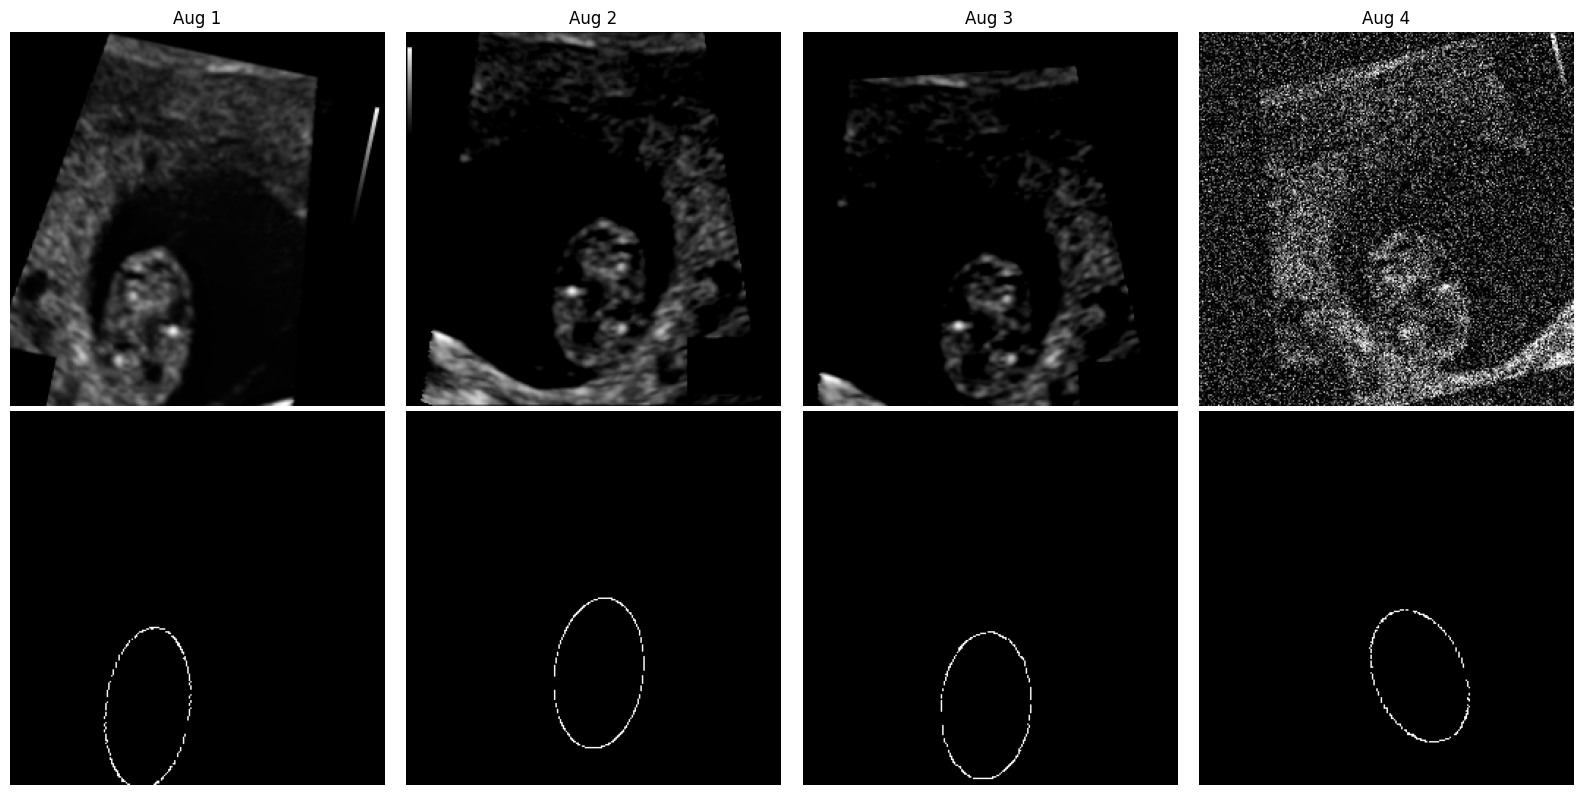

In [ ]:
def get_train_transforms(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.3),  # Removed var_limit
        A.ElasticTransform(alpha=1, sigma=50, p=0.3),  # Removed alpha_affine
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2()
    ])

def get_val_transforms(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2()
    ])

# Visualize augmentations
train_transform = get_train_transforms()
aug_dataset = HCDataset(df, train_dir, transform=train_transform)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    sample = aug_dataset[0]
    img = sample['image'].squeeze().numpy()
    mask = sample['mask'].squeeze().numpy()

    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Aug {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# 5. UNet model

In [ ]:
class MultiTaskUNet(nn.Module):
    def __init__(self, encoder_name='resnet34', encoder_weights='imagenet', in_channels=1):
        super(MultiTaskUNet, self).__init__()

        # Segmentation branch (UNet)
        self.segmentation_model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=1,
            activation=None  # We'll apply sigmoid in forward
        )

        # Get encoder output channels for regression head
        # We'll extract features from the encoder's bottleneck
        if encoder_name.startswith('resnet'):
            encoder_channels = 512  # ResNet34/50 bottleneck
        else:
            encoder_channels = 512  # Default

        # Regression branch
        # Global pooling + FC layers for regression
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.regression_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(encoder_channels, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Pass through the full segmentation model
        seg_output = self.segmentation_model(x)
        seg_output = torch.sigmoid(seg_output)

        # Get encoder features for regression
        # We need to manually pass through encoder to get bottleneck features
        encoder_features = self.segmentation_model.encoder(x)

        # Use the last encoder feature (bottleneck) for regression
        bottleneck_features = encoder_features[-1]
        pooled_features = self.global_pool(bottleneck_features)
        hc_output = self.regression_head(pooled_features)

        return seg_output, hc_output

# Test model
model = MultiTaskUNet().to(device)
test_input = torch.randn(2, 1, 256, 256).to(device)
seg_out, hc_out = model(test_input)

print(f"Segmentation output shape: {seg_out.shape}")  # (2, 1, 256, 256)
print(f"HC output shape: {hc_out.shape}")  # (2, 1)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Segmentation output shape: torch.Size([2, 1, 256, 256])
HC output shape: torch.Size([2, 1])

Total parameters: 24,594,450


# 6. Loss funcs

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, seg_weight=1.0, reg_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()
        self.mae_loss = nn.L1Loss()
        self.seg_weight = seg_weight
        self.reg_weight = reg_weight

    def forward(self, seg_pred, seg_target, hc_pred, hc_target):
        # Segmentation loss (Dice + BCE)
        dice = self.dice_loss(seg_pred, seg_target)
        bce = self.bce_loss(seg_pred, seg_target)
        seg_loss = dice + bce

        # Regression loss (MAE)
        reg_loss = self.mae_loss(hc_pred, hc_target)

        # Combined loss
        total_loss = self.seg_weight * seg_loss + self.reg_weight * reg_loss

        return total_loss, seg_loss, reg_loss

# Test loss
criterion = CombinedLoss(seg_weight=1.0, reg_weight=0.1)
test_seg_pred = torch.rand(2, 1, 256, 256)
test_seg_target = torch.randint(0, 2, (2, 1, 256, 256)).float()
test_hc_pred = torch.rand(2, 1) * 100
test_hc_target = torch.rand(2, 1) * 100

total, seg, reg = criterion(test_seg_pred, test_seg_target, test_hc_pred, test_hc_target)
print(f"Total loss: {total.item():.4f}")
print(f"Seg loss: {seg.item():.4f}")
print(f"Reg loss: {reg.item():.4f}")

Total loss: 4.8909
Seg loss: 1.4979
Reg loss: 33.9296


# 7. Training + Validation Func

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_mae = 0.0

    pbar = tqdm(dataloader, desc=f'Epoch {epoch} [TRAIN]')
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        hc_values = batch['hc'].to(device)

        optimizer.zero_grad()

        # Forward pass
        seg_pred, hc_pred = model(images)

        # Calculate loss
        total_loss, seg_loss, reg_loss = criterion(seg_pred, masks, hc_pred, hc_values)

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Metrics
        mae = torch.abs(hc_pred - hc_values).mean()

        running_loss += total_loss.item()
        running_seg_loss += seg_loss.item()
        running_reg_loss += reg_loss.item()
        running_mae += mae.item()

        pbar.set_postfix({
            'loss': total_loss.item(),
            'mae': mae.item()
        })

    num_batches = len(dataloader)
    return {
        'loss': running_loss / num_batches,
        'seg_loss': running_seg_loss / num_batches,
        'reg_loss': running_reg_loss / num_batches,
        'mae': running_mae / num_batches
    }

def validate_epoch(model, dataloader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0

    all_pred_hc = []
    all_true_hc = []
    all_pred_hc_from_mask = []

    pbar = tqdm(dataloader, desc=f'Epoch {epoch} [VAL]')
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            hc_values = batch['hc'].to(device)
            pixel_sizes = batch['pixel_size'].cpu().numpy()

            # Forward pass
            seg_pred, hc_pred = model(images)

            # Calculate loss
            total_loss, seg_loss, reg_loss = criterion(seg_pred, masks, hc_pred, hc_values)

            running_loss += total_loss.item()
            running_seg_loss += seg_loss.item()
            running_reg_loss += reg_loss.item()

            # Store predictions from regression head
            all_pred_hc.extend(hc_pred.cpu().numpy().flatten().tolist())
            all_true_hc.extend(hc_values.cpu().numpy().flatten().tolist())

            # Calculate HC from predicted masks
            seg_pred_np = (seg_pred.cpu().numpy() > 0.5).astype(np.uint8)
            for i in range(len(seg_pred_np)):
                mask_pred = (seg_pred_np[i, 0] * 255).astype(np.uint8)
                pixel_size = pixel_sizes[i, 0] if len(pixel_sizes.shape) > 1 else pixel_sizes[i]
                hc_from_mask = calculate_hc_from_mask(mask_pred, pixel_size)
                # Ensure it's a scalar
                if isinstance(hc_from_mask, np.ndarray):
                    hc_from_mask = float(hc_from_mask.item())
                elif isinstance(hc_from_mask, (list, tuple)):
                    hc_from_mask = float(hc_from_mask[0])
                else:
                    hc_from_mask = float(hc_from_mask)
                all_pred_hc_from_mask.append(hc_from_mask)

    num_batches = len(dataloader)

    # Calculate MAE
    mae_regression = mean_absolute_error(all_true_hc, all_pred_hc)
    mae_from_mask = mean_absolute_error(all_true_hc, all_pred_hc_from_mask)

    return {
        'loss': running_loss / num_batches,
        'seg_loss': running_seg_loss / num_batches,
        'reg_loss': running_reg_loss / num_batches,
        'mae_regression': mae_regression,
        'mae_from_mask': mae_from_mask,
        'predictions': all_pred_hc,
        'predictions_from_mask': all_pred_hc_from_mask,
        'ground_truth': all_true_hc
    }

# 8. (Bonus) Save results

In [3]:
df = df_clean.copy()
# Configuration
config = {
    'image_size': 256,
    'batch_size': 16,
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'encoder_name': 'resnet34',
    'seg_weight': 1.0,
    'reg_weight': 0.1,
    'k_folds': 5,
    'patience': 5
}

# K-Fold Cross Validation
kfold = KFold(n_splits=config['k_folds'], shuffle=True, random_state=42)
fold_results = []

# Create directory for saving models
os.makedirs('/content/models', exist_ok=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{config['k_folds']}")
    print(f"{'='*50}\n")

    # Split data
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

    # Create datasets
    train_dataset = HCDataset(
        train_df,
        train_dir,
        transform=get_train_transforms(config['image_size'])
    )
    val_dataset = HCDataset(
        val_df,
        train_dir,
        transform=get_val_transforms(config['image_size'])
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model
    model = MultiTaskUNet(
        encoder_name=config['encoder_name'],
        encoder_weights='imagenet',
        in_channels=1
    ).to(device)

    # Loss and optimizer
    criterion = CombinedLoss(
        seg_weight=config['seg_weight'],
        reg_weight=config['reg_weight']
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5  # Removed verbose
    )

    # Storage for tracking metrics
    fold_history = {
        'train_loss': [],
        'train_mae': [],
        'val_loss': [],
        'val_mae_regression': [],
        'val_mae_from_mask': [],
        'learning_rates': []
    }

    # Training loop
    best_mae = float('inf')
    patience_counter = 0

    for epoch in range(1, config['num_epochs'] + 1):
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, epoch)

        # Validate
        val_metrics = validate_epoch(model, val_loader, criterion, device, epoch)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Scheduler step
        old_lr = current_lr
        scheduler.step(val_metrics['mae_regression'])
        new_lr = optimizer.param_groups[0]['lr']

        # Print LR change if it happened
        if old_lr != new_lr:
            print(f"Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}")

        # Store metrics
        fold_history['train_loss'].append(train_metrics['loss'])
        fold_history['train_mae'].append(train_metrics['mae'])
        fold_history['val_loss'].append(val_metrics['loss'])
        fold_history['val_mae_regression'].append(val_metrics['mae_regression'])
        fold_history['val_mae_from_mask'].append(val_metrics['mae_from_mask'])
        fold_history['learning_rates'].append(new_lr)

        print(f"\nEpoch {epoch}:")
        print(f"Train Loss: {train_metrics['loss']:.4f} | Train MAE: {train_metrics['mae']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f} | Val MAE (regression): {val_metrics['mae_regression']:.4f} | Val MAE (from mask): {val_metrics['mae_from_mask']:.4f}")

        # Save best model
        if val_metrics['mae_regression'] < best_mae:
            best_mae = val_metrics['mae_regression']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_mae': best_mae,
                'fold': fold,
                'config': config
            }, f'/content/best_model_fold_{fold+1}.pth')

            print(f"Saved best model with MAE: {best_mae:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config['patience']:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            break

    # Store fold results
    fold_results.append({
        'fold': fold + 1,
        'best_mae': best_mae,
        'final_predictions': val_metrics['predictions'],
        'final_ground_truth': val_metrics['ground_truth'],
        'history' : fold_history
    })

# Summary across all folds
print(f"\n{'='*50}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*50}\n")

fold_maes = [result['best_mae'] for result in fold_results]
print(f"Fold MAEs: {fold_maes}")
print(f"Mean MAE: {np.mean(fold_maes):.4f} ± {np.std(fold_maes):.4f}")

Run summary:

fold_1_mae   12.48523
fold_2_mae   11.12079
fold_3_mae   11.88343
fold_4_mae   13.48694
fold_5_mae   11.65854
max_mae      13.48694
mean_mae     12.12699
min_mae      11.12079
std_mae       0.80858


# 9. Visualize

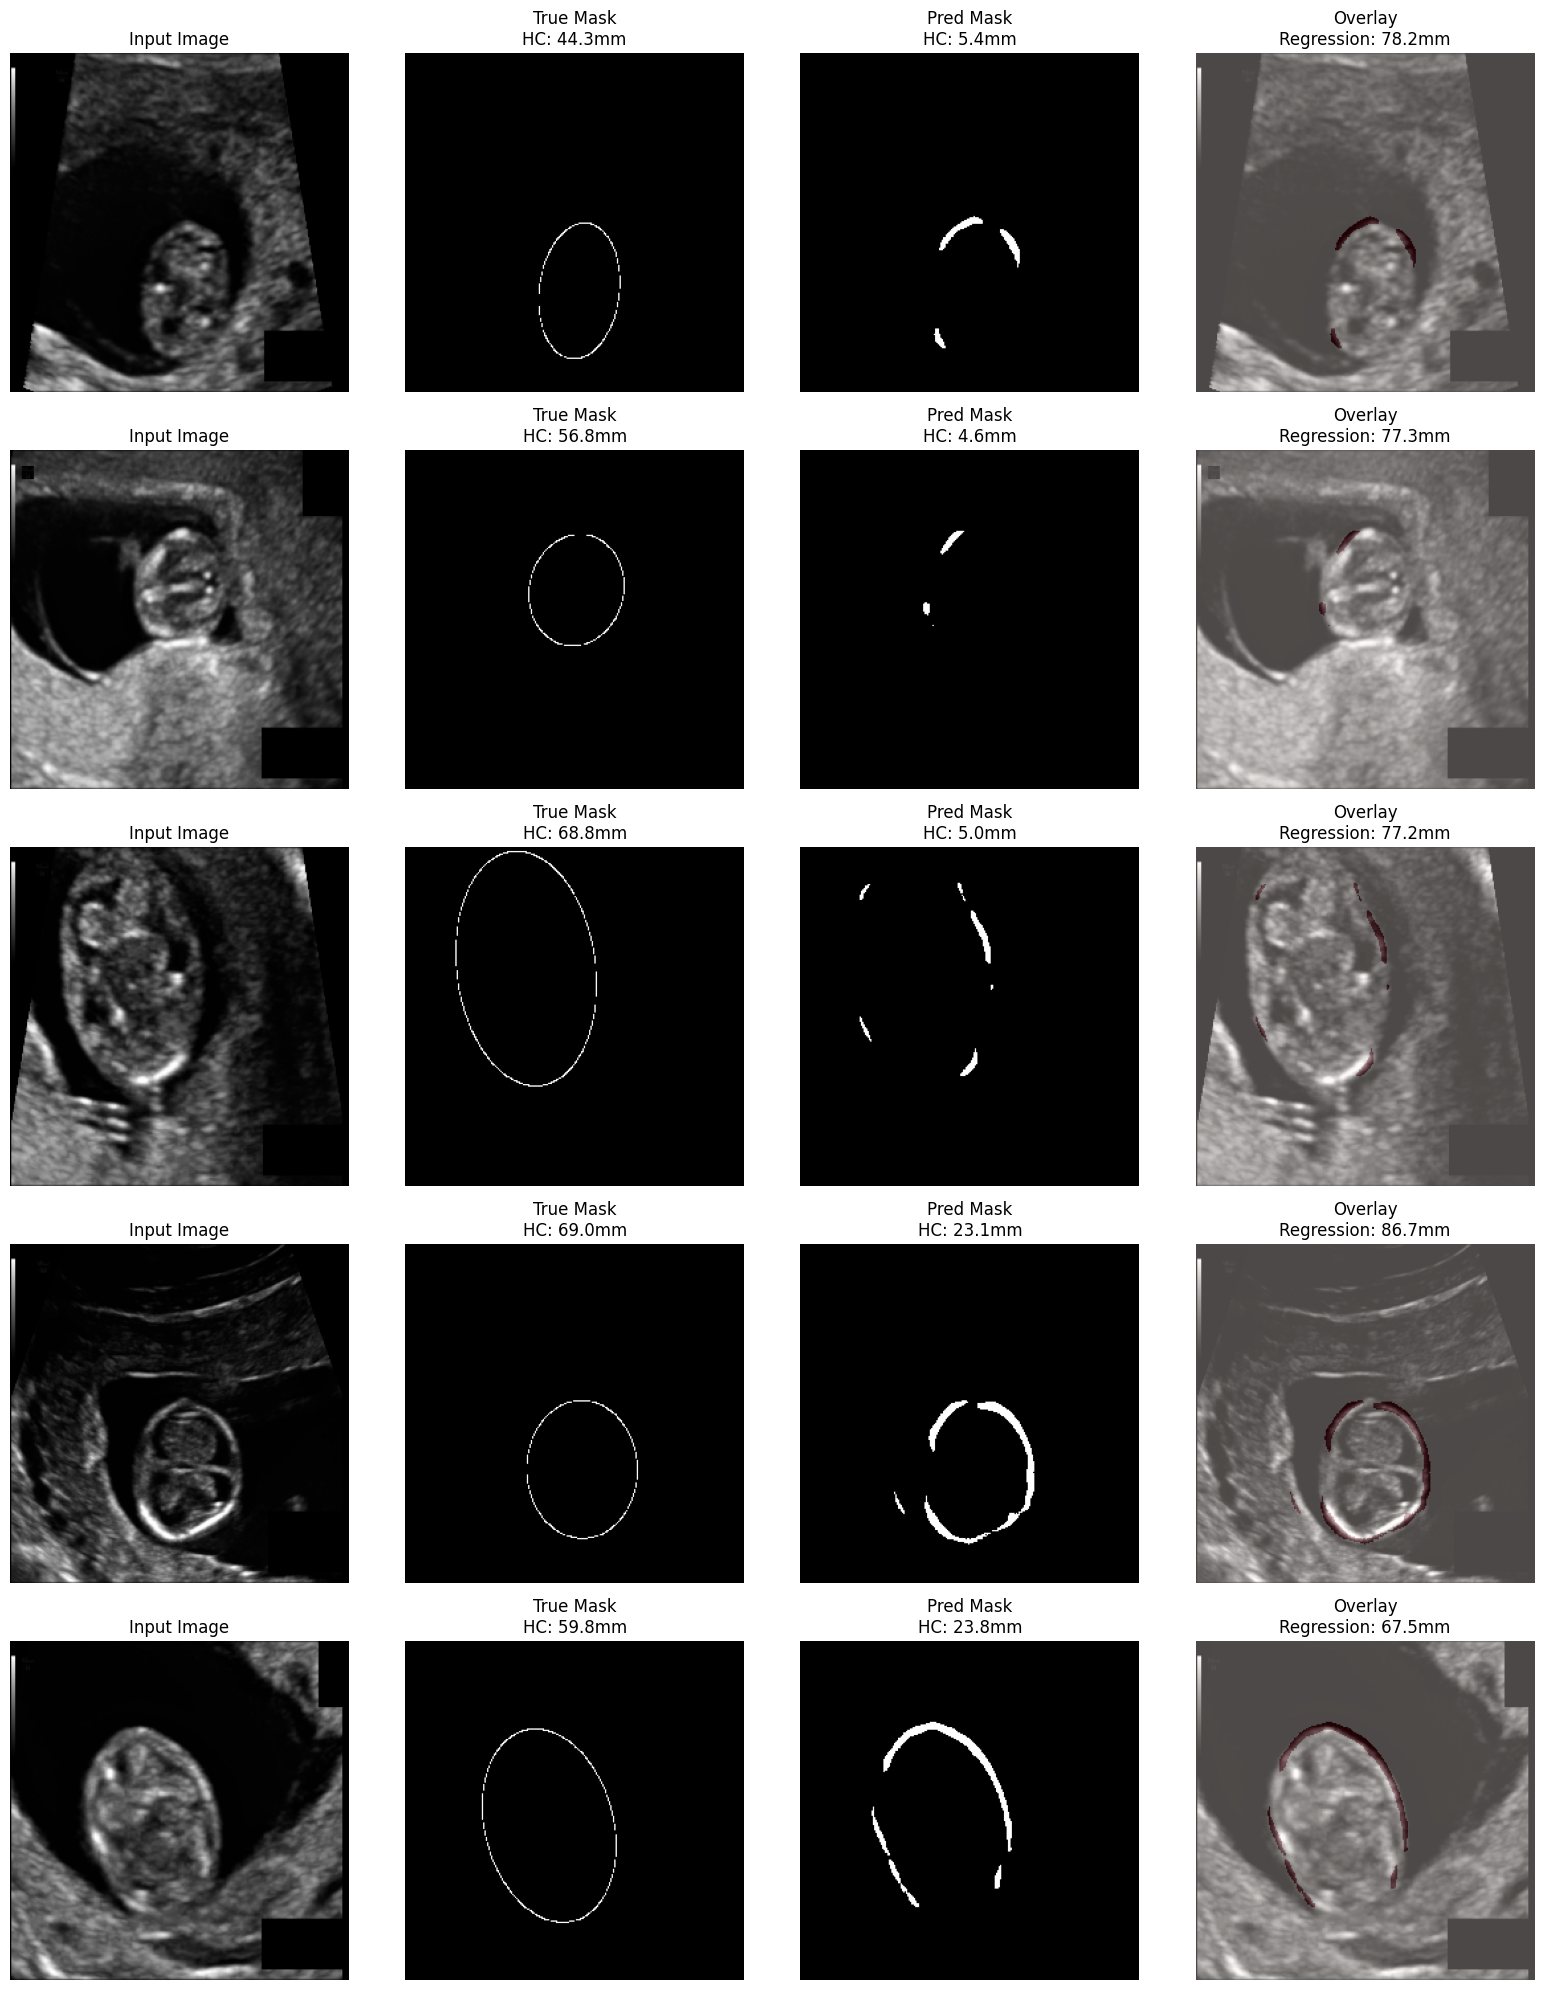

In [ ]:
# Load best model from fold 1 for visualization
checkpoint = torch.load('/content/best_model_fold_1.pth')
model = MultiTaskUNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get some validation samples
val_dataset = HCDataset(df.iloc[:5], train_dir, transform=get_val_transforms(256))

fig, axes = plt.subplots(5, 4, figsize=(16, 20))

with torch.no_grad():
    for i in range(5):
        sample = val_dataset[i]
        image = sample['image'].unsqueeze(0).to(device)
        true_mask = sample['mask'].squeeze().numpy()
        true_hc = sample['hc'].item()
        pixel_size = sample['pixel_size'].item()

        # Predict
        seg_pred, hc_pred = model(image)

        # Convert to numpy
        img_np = sample['image'].squeeze().numpy()
        pred_mask = (seg_pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        pred_hc = hc_pred.item()

        # Calculate HC from mask
        hc_from_mask = calculate_hc_from_mask(pred_mask * 255, pixel_size)

        # Plot
        axes[i, 0].imshow(img_np, cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title(f'True Mask\nHC: {true_hc:.1f}mm')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f'Pred Mask\nHC: {hc_from_mask:.1f}mm')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(img_np, cmap='gray')
        axes[i, 3].imshow(pred_mask, cmap='Reds', alpha=0.3)
        axes[i, 3].set_title(f'Overlay\nRegression: {pred_hc:.1f}mm')
        axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('/content/predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()


Processing Fold 1...
Saved: /content/fold_1_visualization.png


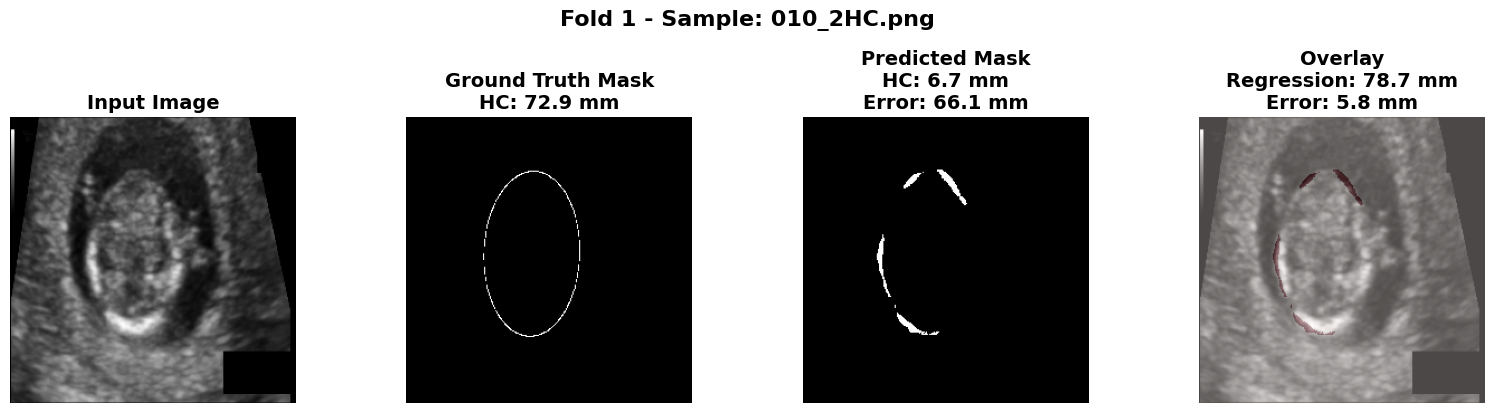


Processing Fold 2...
Saved: /content/fold_2_visualization.png


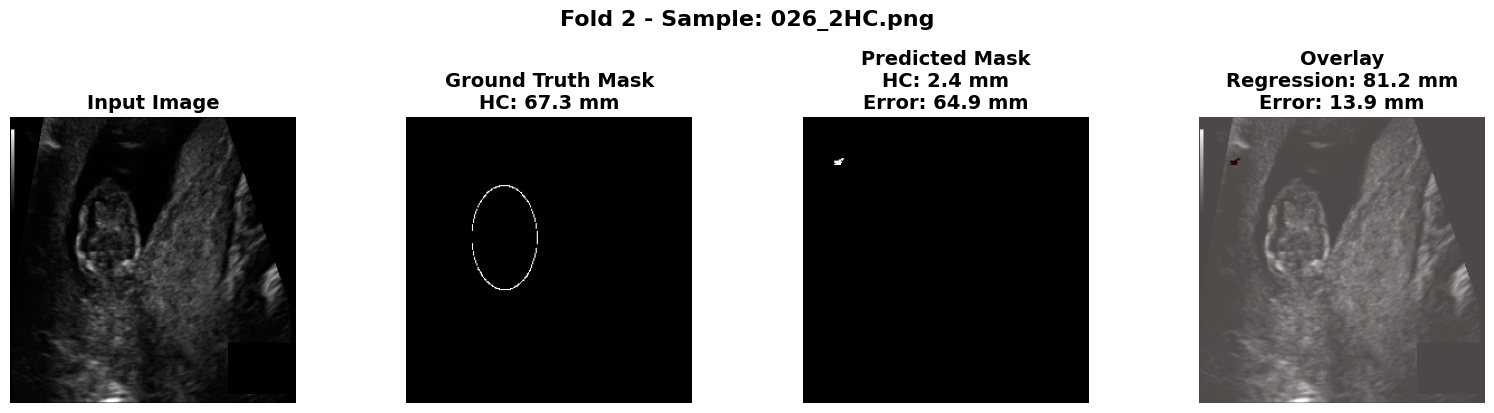


Processing Fold 3...
Saved: /content/fold_3_visualization.png


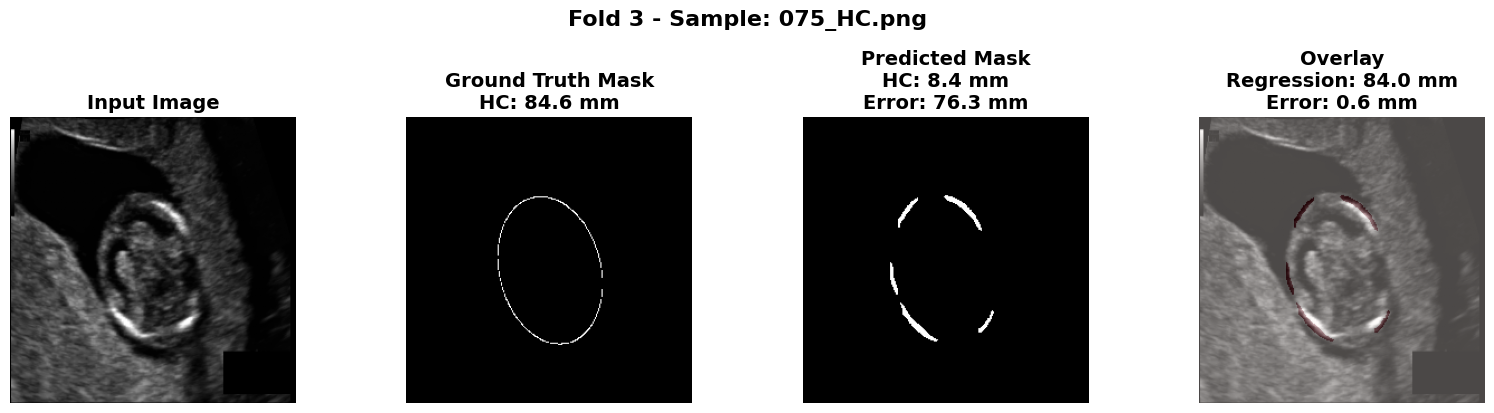


Processing Fold 4...
Saved: /content/fold_4_visualization.png


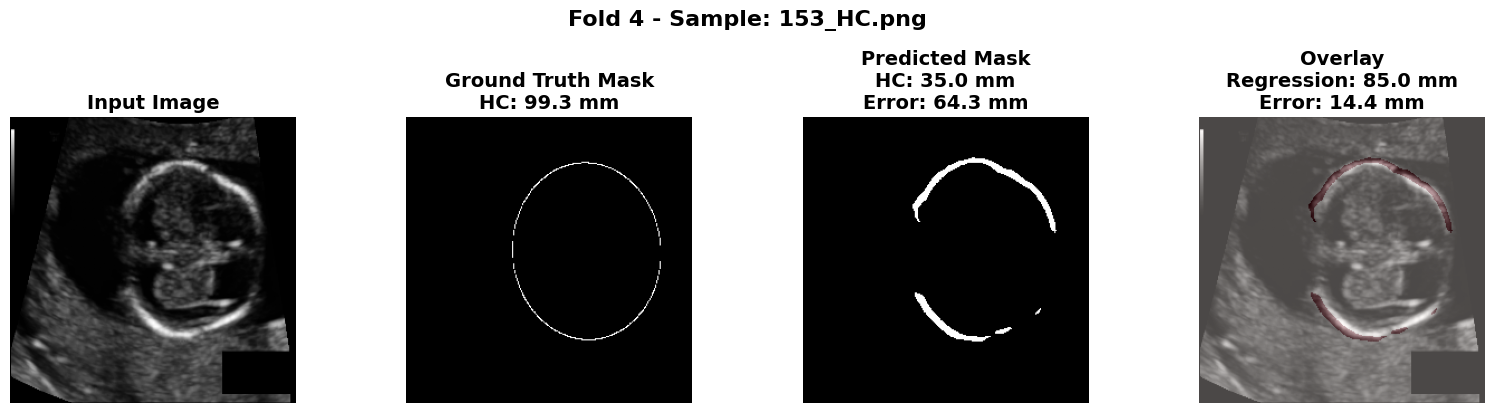


Processing Fold 5...
Saved: /content/fold_5_visualization.png


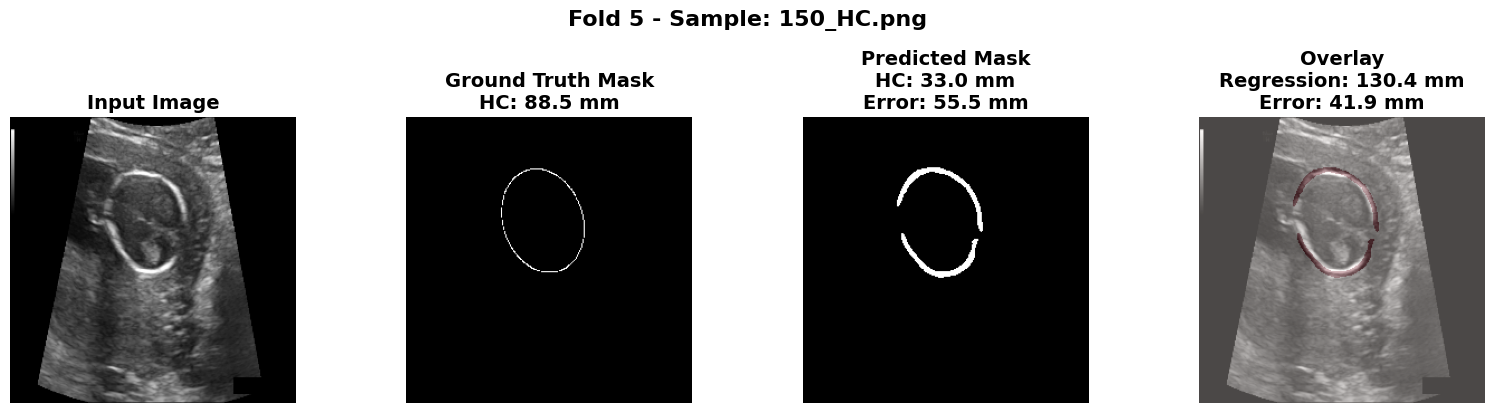


Generated files:
fold_1_visualization.png
fold_2_visualization.png
fold_3_visualization.png
fold_4_visualization.png
fold_5_visualization.png


In [ ]:
# Recreate the K-fold splits to get the exact validation sets
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df)):
    fold_num = fold_idx + 1

    print(f"\nProcessing Fold {fold_num}...")

    # Load the best model for this fold
    model_path = f'/content/best_model_fold_{fold_num}.pth'

    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        continue

    checkpoint = torch.load(model_path)
    model = MultiTaskUNet().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Get validation dataframe for this fold
    val_df = df.iloc[val_idx]

    # Pick one sample from this fold's validation set
    # Use different indices for variety: 0, 10, 20, 30, 40
    sample_idx = min(fold_idx * 10, len(val_df) - 1)

    # Create dataset with just this one sample
    sample_df = val_df.iloc[sample_idx:sample_idx+1]
    val_dataset = HCDataset(sample_df, train_dir, transform=get_val_transforms(256))

    # Create figure for this fold (1 row, 4 columns)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    with torch.no_grad():
        sample = val_dataset[0]
        image = sample['image'].unsqueeze(0).to(device)
        true_mask = sample['mask'].squeeze().cpu().numpy()
        true_hc = sample['hc'].item()
        pixel_size = sample['pixel_size'].item()
        filename = sample['filename']

        # Predict
        seg_pred, hc_pred = model(image)

        # Convert to numpy
        img_np = sample['image'].squeeze().cpu().numpy()
        pred_mask = (seg_pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        pred_hc = hc_pred.item()

        # Calculate HC from mask
        hc_from_mask = calculate_hc_from_mask(pred_mask * 255, pixel_size)

        # Calculate errors
        error_regression = abs(pred_hc - true_hc)
        error_from_mask = abs(hc_from_mask - true_hc)

        # Plot
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(true_mask, cmap='gray')
        axes[1].set_title(f'Ground Truth Mask\nHC: {true_hc:.1f} mm',
                         fontsize=14, fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title(f'Predicted Mask\nHC: {hc_from_mask:.1f} mm\nError: {error_from_mask:.1f} mm',
                         fontsize=14, fontweight='bold')
        axes[2].axis('off')

        axes[3].imshow(img_np, cmap='gray')
        axes[3].imshow(pred_mask, cmap='Reds', alpha=0.3)
        axes[3].set_title(f'Overlay\nRegression: {pred_hc:.1f} mm\nError: {error_regression:.1f} mm',
                         fontsize=14, fontweight='bold')
        axes[3].axis('off')

    # Add main title with fold info and filename
    fig.suptitle(f'Fold {fold_num} - Sample: {filename}',
                 fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()

    # Save individual image for this fold
    save_path = f'/content/fold_{fold_num}_visualization.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")

    plt.show()
    plt.close()

print("\nGenerated files:")
for i in range(1, 6):
    print(f"fold_{i}_visualization.png")

# 10. Scatter plot

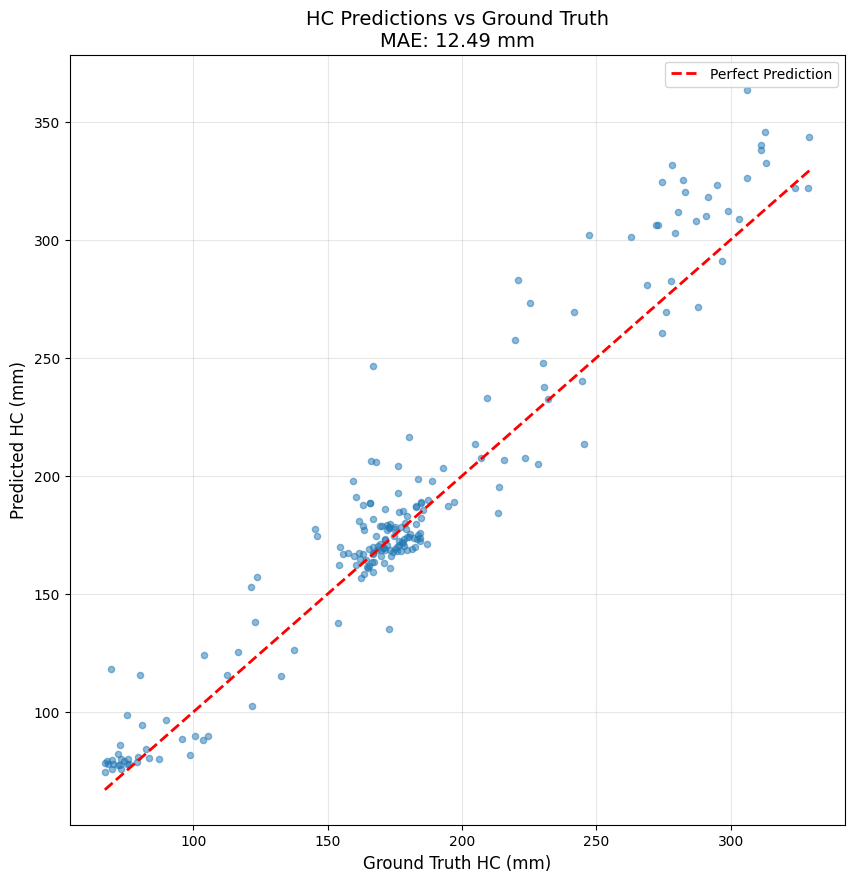

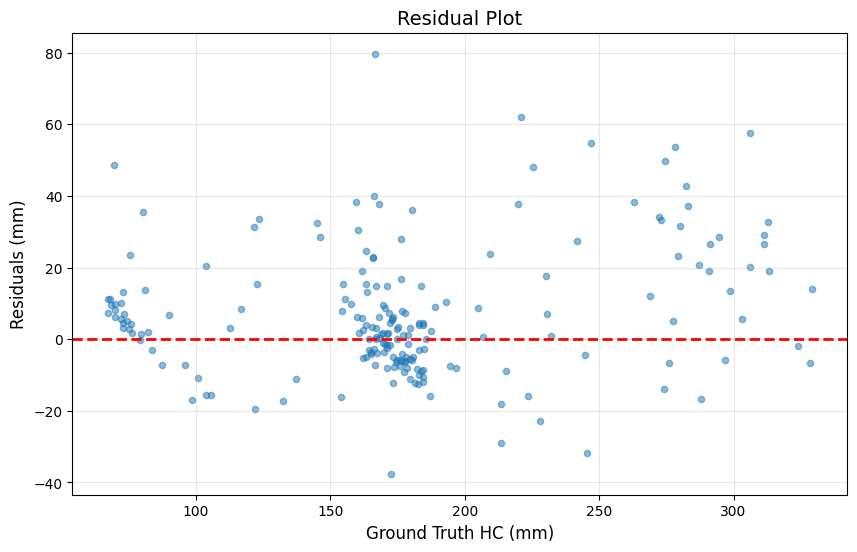

In [ ]:
# Use fold 1 results for plotting
fold_result = fold_results[0]
predictions = fold_result['final_predictions']
ground_truth = fold_result['final_ground_truth']

plt.figure(figsize=(10, 10))
plt.scatter(ground_truth, predictions, alpha=0.5, s=20)
plt.plot([min(ground_truth), max(ground_truth)],
         [min(ground_truth), max(ground_truth)],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Ground Truth HC (mm)', fontsize=12)
plt.ylabel('Predicted HC (mm)', fontsize=12)
plt.title(f'HC Predictions vs Ground Truth\nMAE: {fold_result["best_mae"]:.2f} mm', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/content/scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# Residual plot
residuals = np.array(predictions) - np.array(ground_truth)
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Ground Truth HC (mm)', fontsize=12)
plt.ylabel('Residuals (mm)', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('/content/residual_plot.png', dpi=150, bbox_inches='tight')
plt.show()